# Introduction to Data Analysis Techniques for Cosmic Microwave Background  Maps

Original by:  Jeff McMahon and Renée Hložek 

Some edits by J. Ruhl (6/2023)

The Cosmic Microwave Background (CMB) is the oldest observable light in the universe. As such it carries a wealth of cosmological information including: (1) signals from the early universe (primary anisotropy), and (2) distortions imprinted as this light propagates through the universe and encounters collapsed structures (secondary anisotropy).  Measurements of these signals give us important measurements and constraints on inflationary parameters, dark energy, dark matter, the sum of the neutrino masses, and many astrophysical processes.  The development of CMB instruments and analysis techniques is rapidly evolving.

This notebook provides an introduction to analysis techniques for CMB maps as they pertain to high resolution CMB instruments such as the Atacama Cosmology Telescope (ACT) and the South Pole Telescope (SPT).  These state of the art instruments have thousands of detectors (pixels) deployed on 6 and 10 meter telescopes which produce arc minute resolution beams at 150 GHz.  These telescopes observe by scanning across the sky.  The data from each detector are read out at high speed (typically > 50 Hz) to produce 'detector time streams' which are recorded along with pointing information and other ancillary data.  Sophisticated codes are used to convert these time streams into maps of the CMB sky.  These maps can have correlated noise that must be accounted for in data analysis.   The mapmaking algorithms are not described here but represent a very interesting big data challenge as they require cleaning time streams by filtering, identifying transient events, and ultimately compressing ~Tb of data down to maps that are typically 100 Mb or less.  

Here are example maps from SPT (top, taken from a phys.org article from April 2, 2012 titled "South Pole Telescope hones in on dark energy, neutrinos") and ACTPol (bottom, taken from the Naess et al. 2014 CMB polarization paper).  Many features are obvious in these maps including: (1) the primary CMB visible as waves in the intensity, (2) active galactic nuclei and other bright astrophysical point sources which manifest as bright dots, (3) clusters of galaxies which show up as darkened point sources, and (4) horizontal stripes (in the SPT map) that are the result of the noise and map filtering.  The ACTPol figure shows multiple maps; the T is temperature, Q and U are linear polarization, and E and B are also linear polarization but decomposed into a basis such that the E is the amplitude of the curl-free component, and B is the amplitude of the divergence free component of the polarization vector field.

![](http://cdn.phys.org/newman/gfx/news/hires/2012/newcosmologi.jpg)

![](http://www.classe.cornell.edu/rsrc/Home/NewsAndEvents/CornellExperimentalCosmologyNews20140528/maps_b.png)



While the current instruments (ACTPol and SPTPol) have multiple frequencies and polarization sensitivity, for simplicity we consider only a single frequency (150 GHz) and only temperature.  Adding extra frequency channels or polarization add the cost of slightly more work and would make this presentation more confusing.  Therefore we leave these complications for a future treatment and focus on temperature alone.  This allows us to show the basics of Monte Carlo analysis of both the angular power spectrum and matched filter techniques for studying Sunyaev-Zeldovich (SZ) effect.

The short course is organized as follows.   We beginning by building a simulation of the CMB sky including the primary CMB, point sources (AGN and dusty galaxies), the SZ effect, and (if time allows) CMB lensing.   To these maps, we fold in instrumental effects including the beam, instrument noise and atmospheric noise.  We then present several analysis techniques including Monte Carlo estimation of power spectra and matched filter techniques for extraction of sources    An example of a stacking analysis is presented as an example of a cross-correlation with external data sets.  Cross-correlation is a very active field of research.

In the interest of simplicity we use approximate distributions for source and SZ counts with combinations of exponential and poisson distributions.   We note explicitly where we make these approximations.

## Code preliminaries
We use the following libraries in this code.  All are available through Anaconda.

In [17]:
import numpy as np
#import matplotlib
#import sys
import matplotlib.cm as cmap
#import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits

## ipython notebook magic word to plot in the notebook
%matplotlib inline
plt.rcParams.update({'font.size': 14})  # Sets font size used in figures
plt.rcParams['figure.figsize'] = [8,8] # Sets figure sizes, change this before each plot to customize.


## CMB power spectra conventions:  $C_\ell$ and $D_\ell$
We are going to generate a simulated set of maps [(T,Q,U) or (T,E,B)] of the CMB sky using a set of spectra read in from a file generated by camb.  Those power spectra are functions of Legendre $\ell$, which is appropriate for working with Ylm's on a sphere.  In the spherical case, the map is given by 

$$ T(\theta,\phi) = \sum_{\ell,m} a_{\ell,m} Y_{\ell,m}(\theta, \phi) .$$

The angular correlation function, ie the expectation value of the product of the temperatures of two points on the sky separated by an angle $\theta$, is 

$$ C(\theta) = \left< \Delta T(\psi) \Delta T(\psi + \theta) \right> = 
            \frac{1}{4\pi} \sum_\ell \sum_{m=-\ell}^{m=+\ell} |a_{\ell,m}|^2 P_\ell(\cos \theta) \ .$$
            
The mean square temperature fluctuations (aka the $(rms)^2$) is found by setting $\theta=0$, and noting that $P_\ell(1) = 1$ for all $\ell$,

$$ C(0) = \left< (\Delta T)^2 \right> = 
   \frac{1}{4\pi} \sum_\ell \sum_{m=-\ell}^{m=+\ell} |a_{\ell,m}|^2 \ . $$

Thus, we can find the rms of a particular CMB temperature map if we are given all the $a_{\ell,m}$'s, by summing over their squares and taking the square root.  

Cosmological models don't predict individual $a_{\ell,m}$'s, because the values of those depend on the direction you set your $z$ axis, and are expected to be distributed about zero in a Gaussian fashion.  What is predictable is the spread of that Gaussian as a function of $\ell$, which can be specified by 

$$ C_\ell \equiv \left< |a_{\ell,m}|^2 \right> \ ,$$

where the average is over an ensemble (and m) when we're thinking about model predictions, or over $m$ if we're using an actual map to try to measure $C_\ell$'s.  Using this in the equation for $C(0)$ above we see
that

$$ \left< (\Delta T)^2 \right> = \frac{1}{4\pi} \sum_\ell (2\ell + 1) C_\ell \ . $$

If $C_\ell$ is flat, ie independent of $\ell$, a range $\Delta \ell$ centered on $\ell_0$, then this further simplifies to 

$$ \left< (\Delta T)^2 \right> \approx \frac{1}{4\pi} \Delta\ell (2\ell_0 + 1) C_\ell \ , $$

and in the special case (which we'll use below as a check of our code) where $C_\ell$ is constant 
from $\ell = 0$ to $\ell_{max}$, 

$$ \left< (\Delta T)^2 \right> \approx \frac{1}{4\pi} \ell_{max} (\ell_{max} + 1) C_\ell \ . $$

You'll usually see CMB power spectra supplied (eg by camb) or plotted with using a value related to $C_\ell$  that is motivated by this idea, with

$$ D_\ell \equiv \frac{1}{2\pi} \ell (\ell+1) C_\ell \approx \frac{1}{4\pi} \ell (2\ell + 1) C_\ell \ . $$

I don't know why that last approximation was made;  we should probably ask Dick Bond, who I believe instigated its use.


## Flat space map representation
The math tools above, $Y_{\ell,m}$'s and $a_{\ell,m}$'s and $C_\ell$'s are great for working on a sphere.  
We want to work instead with "flat sky" maps, which allow us to use convenient numerical tools like Fourier Transforms.  This is reasonable for looking at small fractions of the sky, and becomes less reasonable for larger sections.  It's great for our purposes, and we'll probably stick to sky areas less than say $\sim 30^\circ \times 30^\circ$) or so.

In flat sky maps we'll work with $k_x$ and $k_y$ instead of $\ell$ and $m$, where $1/k$ is the wavelength (in radians) of a given fluctuation mode (think hot spot, to cold, and back to hot) in that map.  In these maps we have

$$ \Delta T(\theta_x, \theta_y) = 
  \frac{1}{N^2} \sum_{k_x} \sum_{k_y} A(k_x, k_y) 
  e^{i 2 \pi (k_x \theta_x + k_y \theta_y)} \  \ \ , $$
  
$$ A(k_x, k_y) = 
  \sum_{\theta_x} \sum_{\theta_y} \Delta T(\theta_x, \theta_y) 
  e^{-i 2 \pi (k_x \theta_x + k_y \theta_y)} \  \ \ , $$

where is $A(k_x, k_y)$ is the amplitude of the Fourier modes, and we've chosen the normalization convention (``backward") that is the default in Numpy, leading to the factor of $1/N^2$ in the first formula, where $N$ is the number of pixels across one edge of our square map.  Parseval's theorem
tells us that 

$$ \left< (\Delta T) ^2  \right> = \frac{1}{N^2} \sum_{k_x} \sum_{k_y} A(k_x, k_y)^2 \ , $$

which we can use to relate the $A$ values to the $C_\ell$'s.  What we notice here is that the $A^2$ are equivalent to the $C_\ell$'s, so if we want to increase a given mode in our flat-sky map to match a peak in the $C_\ell$ power spectrum, we should scale $A$ proportional to $\sqrt{C_\ell}$.  However, we need to know exactly what 
that proportionality factor should be.   We can find this by making sure we set $A$ such that we get the right
value of $ \left< (\Delta T)^2 \right>$;  looking at the equations above and imagining a situation where we have
$C_\ell =$constant out to some value $\ell_{max}$, we see that

$$ \left< (\Delta T)^2 \right> = \frac{1}{4\pi} \ell_{max} (\ell_{max} + 1) C_\ell \ = 
\frac{1}{N^2} \sum_{k_x} \sum_{k_y} A(k_x, k_y)^2   $$

$$ \frac{1}{4\pi} \ell_{max} (\ell_{max} + 1) C_\ell \ = 
\frac{1}{N^2} \frac{\pi k_{max}^2}{dk^2}  A^2  $$

which we can rearrange to give

$$ A^2 = \frac{N^2 dk^2}{4\pi^2 k_{max}^2} \ell_{max} (\ell_{max} + 1) C_\ell \approx 
\frac{N^2 dk^2 \ell_{max}^2 }{4\pi^2 k_{max}^2} C_\ell$$


In practice we're going to use a nice trick, which is to start by making a real-space map with rms = unity ``white noise" in it, then FFT it to k-space, scale the amplitudes of modes in k-space using the $\sqrt{C_\ell}$, and then iFFT it all back to real-space.  This gets around having to worry about the factor of $1/N^2$ because the FFT-iFFT pair take care of that for us.  We just need to figure out how to convert between $\ell$ and $k$.


## $\ell$ vs k
The properties of our 2D, Fourier-plane, k-space grid are determined by the pixel size and the number of pixels across one edge of the map (or equivalently, the angular extent $\theta_{map}$ of the map).  The Nyquist frequency is given by the wavelength of a 2-pixel long wave, ie 

$$k_{ny} = \frac{1}{2 d_{pix}}$$ 

with $d_{pix}$ being the size of a pixel in radians.  The resolution of our k-space grid is given by 

$$dk = \frac{1}{\theta_{map}} = \frac{1}{N d_{pix}} \ .$$



Noting that the CMB dipole is $\ell = 1$ and has a "wavelength" of $2\pi$ radians on the sphere, we can see the relation between $\ell$ and $k$ is 

$$\ell = k* 2 \pi , $$

where $k = \sqrt{k_x^2 + k_y^2}$.  (If you think back to your E&M where $k=2\pi/\lambda$, $\ell$ is like that version of $k$, rather than the $k = 1/\lambda$ we've defined here!)
 
Thus the Nyquist $\ell$ and resolution of our $\ell$-space grid are 

$$ \ell_{ny} = \frac{2 \pi}{2 d_{pix}} \ , $$

$$ d\ell = \frac{2 \pi}{N d_{pix}} \ .$$

We can use all this to simplify the conversion between $A$ and $C_\ell$ above, finding

$$ A^2 \approx \frac{ N^2 \ell^2_{max} }{ 4 \pi^2} \frac{ dk^2}{k_{max}^2} C_\ell
= \frac{ N^2 \ell_{max}^2 }{ 4 \pi^2} \frac{ 4\pi^2}{N^2 d_{pix}^2 \ell_{max}^2} C_\ell $$
$$ A^2 = \frac{1}{d_{pix}^2} C_\ell$$

or

$$ A = \frac{1 }{d_{pix}} \sqrt{C_\ell} \ ,$$

which we will use below.

<hr style="border:2px solid gray">

## Section 1.1: Theoretical Temperature-anisotropy Angular Power Spectrum

As mentioned above, the majority of the information content of a CMB temperature-anisotropy map is contained in its angular power spectrum (the $C_\ell$'s or $D_\ell$'s),
which is very similar to the "one-sided PSD" discussed in the "intro to FFTs" notebook.  

For a given set of input cosmological parameters these spectra can be computed with codes including CMBFAST or the more modern equivalent CAMB.  The spectrum used below was computed with CAMB web interface on NASA's LAMBDA interface.

http://lambda.gsfc.nasa.gov/toolbox/tb_camb_form.cfm

The first thing you may notice is that this spectrum is not "bland" - it has a lot of features!   That's great, 
because this means there's a lot of information in it, from which we can extract cosmological information.  It is fun to play with the input cosmological parameters and see how the spectrum changes. 

The location of the first peak at $\ell \sim 200$ provided the first definitive measurement that space in our universe is globally flat (aka "uncurved").  The shape of the spectrum has been used to constrain a wide variety of cosmological parameters including the energy densities of dark energy and dark matter, and the spectral index (nearly scale invariant) of the density perturbations generated by cosmic inflation.  The fall off at high ell (e.g. $\ell \gtrsim 1000$) is called the "damping tail" and tells us about details of the "clearing" of the
plasma at $z \sim 1000$.

At this point the temperature spectrum is well measured and the open frontiers are polarization and secondary anisotropies that are not shown in this temperature-anisotropy spectrum.   We will now build simulated skies including the CMB "primordial" anisotropies (ie those generated at $z>1000$) and secondary anisotropies (ie those generated after $z=1000$.  After that we will show how to estimate the power spectrum from map data using "Monte Carlo" techniques.   This approach can also be used for interpretation of polarization data and for the interpretation of cross-correlations between CMB and other survey data.

Here is how to read in and plot the CMB temperature spectrum from a CAMB simulation.

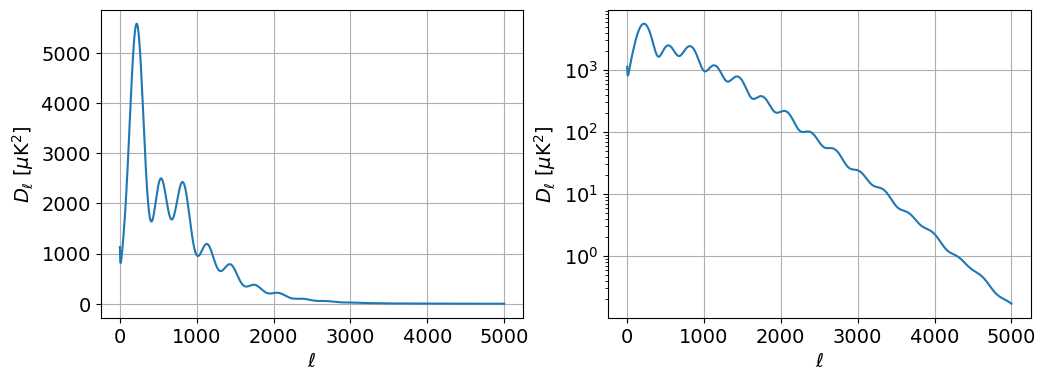

In [158]:
# read in the input CMB spectra
plt.rcParams['figure.figsize'] = [12,4]
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True)

plt.subplot(1,2,1)
plt.plot(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.grid()

plt.subplot(1,2,2)
plt.semilogy(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.grid()


$\ell = 0$ corresponds to a constant temperature across the sky, $\ell = 200$ corresponds approximately to scales of $1^\circ$. 

This plot is the angular power spectrum of the CMB temperature anisotropies.  It is traditional to plot $D_\ell$ which (as discussed above) is related to the variance on various angular scales, and provides a *much* flatter curve.  $C_\ell$ is what appears in most of the formulas we gave above, and is therefore what you really want for making CMB maps, but $D_\ell$ is what is conventionally plotted because it's so much flatter.  (Change the plots above to show $C_\ell$ and you'll see what we mean by that!)

<font color='red'> EXCERCISE: </font>  Go to the NASA LAMBDA CAMB web interface and generate a power spectrum for a for a model universe with a strange component of your choosing (e.g., with spatial curvature, no dark energy, some other bizarre component). Make a plot comparing this power spectrum to the vanilla spectrum above.  

In [159]:
# your code and plots go here

Comment on how your spectrum from this strange model universe compars to the spectrum from standard cosmology here.

## Section 1.2: "Flat-sky" Temperature Anisotropy Map
In this step we generate a simulated map of the CMB sky with the spectrum we read in above.  Since the power spectrum provided by camb is a function of $\ell$ we need to do much of the work in harmonic space.  If we were generating a map on the full sky we would need to work with spherical harmonics, which you can do using the healpy library.  Here we consider a small patch of sky ($\sim 10^\circ \times 10^\circ$) were we can use the 'flat-sky' approximation and replace $\ell$ with $k = \sqrt{k_x^2 + k_y^2}$, with $\ell = k* 2 \pi$ as discussed above.
 
In the flat sky approximation we generate a CMB map by:  
1. Setting the parameters of the desired map:  pixel size, angular extent, number of pixels across one side.
2. Using that information to determine the (kx, ky) values (and therefore k as well) of the pixels in the Fourier-space version of that map,
3. Generating a 2D power spectrum by revolving the relevant power spectrum (properly normalized to account for the $\Delta k$ spacing of our pixels in Fourier space) about the "k=0" axis in the Fourier space map, in polar coordinates, correctly scaling $\ell$ to $k$, to generate PS_kspace.
4. generating a Gaussian random map (in real space, not Fourier space, with unit variance as our 'random realisation', then taking its Fourier transform to generate FT_map,
5. multiplying FT_map and PS_kspace to get a properly shaped, randomly-realized, FT of a cmb map,
6. Inverse Fourier transforming this to get our final real-space map.  

In the next cell we provide a function to do this, as well as a function to plot this (and other maps) with a uniform color scale.

In [160]:
def make_CMB_T_map(N,pix_size,ell,DlTT):
    '''
    Makes a realization of a simulated CMB "square, flat sky" map given:
    
      N: the (integer) number of pixels across one edge of the (square) output map.
      pix_size:  the pixel size in arcminutes,
      ell: a numpy vector that runs from 0 to the maximum ell, and which must be spaced with delta_ell = 1 between elements.
      DlTT:  the input numpy vector containing DlTT as a function of ell,
    The output map is N x N pixels, covering an angular area (N*pix_size) x (N*pix_size) on the sky.
    
    The input values of the monopole and dipole (ell=0 and 1) in the DlTT vector are set to zero.
    '''
    
    # convert Dl to Cl
    ClTT = DlTT * 2 * np.pi / (ell*(ell+1.))
    ClTT = np.where((ell <= 1),0,ClTT)
    #ClTT[0] = 0. # set the monopole to zero.
    #ClTT[1] = 0. # set the dipole to zero.
    
    
    # Make 2D arrays that have the values of k_x and k_y in them.
    # X and Y run from -0.5 and +0.5, each of length N
    pix_radians = (pix_size/60. * np.pi/180.) # going from pix_size in arcmins to degrees and then degrees to radians
    k_ny = 1/(2*pix_radians)
    X,Y = np.meshgrid(np.linspace(-1,1,N),np.linspace(-1,1,N)) ## make 2d arrays of x and y coordinates
    R = np.sqrt(X**2 + Y**2)  ## calculate the radial coordinate of each pixel
    # 2D arrays with k_x, k_y, and k_r == k_tot in them.
    k_x = k_ny*X
    k_y = k_ny*Y
    k_r = k_ny*R
    
    # 2D arrays with ell_x, ell_y and ell2d==ell_tot in them.
    ell_x = 2*np.pi*k_x
    ell_y = 2*np.pi*k_y
    ell2d = 2*np.pi*k_r
    
    # Create a 2D array that has the value of C_ell in it for each ell2d value.  That is,
    # it's the ClTT vector revolved around the center ell=0 point in this 2D array.  To do this
    # we are going to round the values in ell2D to the nearest integer, then take that element of the ClTT vector.
    #
    ClTT_expanded = np.zeros(int(ell2d.max())+1) 
    # making an expanded Cl spectrum (of zeros) that goes all the way to the size of the 2D ell vector
    ClTT_expanded[0:(ClTT.size)] = ClTT # fill in the Cls until the max of the ClTT vector

    # the 2D Cl spectrum is defined on the multiple vector set by the pixel scale
    CLTT2d = ClTT_expanded[ell2d.astype(int)]  #a = b[c], where b is a vector but a and c are 2D arrays!
    #plt.imshow(np.log(CLTT2d))
   
    # now make a realization of the CMB with the given power spectrum in real space
    random_array_for_T = np.random.normal(0,1,(N,N))  # mean zero, std=1
    #
    # Next, we take the FFT to get to k-space, ie ell-space.
    # We don't bother using fftshift because this is white noise, so we don't have to!
    FT_random_array_for_T = np.fft.fft2(random_array_for_T)   
    
    # Now, shape the "white noise 2D power spectrum" into a "CMB-shaped 2D noise power spectrum".
    # At this point, k=0 is at the center of the array and we need to be careful about fftshifts.
    print(FT_random_array_for_T.shape)
    FT_2d = np.sqrt(CLTT2d) * FT_random_array_for_T # we take the sqrt since the power spectrum is T^2
    #plt.imshow(np.real(FT_2d))
        
    ## make a plot of the 2D cmb simulated map in Fourier space, note the x and y axis labels need to be fixed
    #Plot_CMB_Map(np.real(np.conj(FT_2d)*FT_2d*ell2d * (ell2d+1)/2/np.pi),0,np.max(np.conj(FT_2d)*FT_2d*ell2d * (ell2d+1)/2/np.pi),ell2d.max(),ell2d.max())  ###
    
    # move back from ell space to real space
    CMB_T = np.fft.ifft2(np.fft.fftshift(FT_2d))  # note that we fftshifted before ifft-ing.
    
    # move back to pixel space for the map.
    # This is actually a terrible thing.  It's related to Parseval's theorem, and the units for C_ell's.
    CMB_T = (1/pix_radians)*CMB_T
    # we only want to plot the real component.  (The imaginary component should be zero within rounding errors.)
    CMB_T = np.real(CMB_T)
    
    

    ## return the map
    return(CMB_T)
  ###############################
    

def Plot_CMB_Map(Map_to_Plot,c_min,c_max,X_width,Y_width):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    print("map mean: {0:8.5f},  map rms: {1:8.5f}".format(np.mean(Map_to_Plot),np.std(Map_to_Plot)))
    #plt.gcf().set_size_inches(10, 10)
    im = plt.imshow(Map_to_Plot, interpolation='bilinear', origin='lower',cmap=cmap.RdBu_r)
    #im.set_clim(c_min,c_max)
    ax=plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = plt.colorbar(im, cax=cax)
    #cbar = plt.colorbar()
    im.set_extent([0,X_width,0,Y_width])
    plt.ylabel('angle $[^\circ]$')
    plt.xlabel('angle $[^\circ]$')
    cbar.set_label('tempearture [uK]', rotation=270)
    
    plt.show()
    return(0)
    ###############################  
    

Expected rms from C_ell = 111.45593
(4096, 4096)
map mean: -6.56276,  map rms: 107.42052


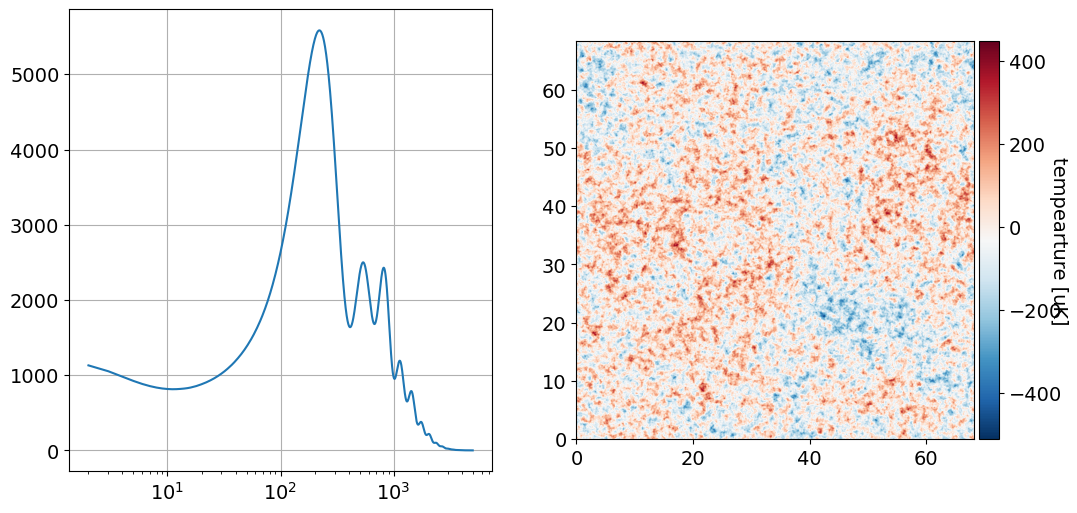

First ells:  [2. 3. 4. 5. 6.]
First Cls:   [1183.75211187  550.87827181  307.70329246  193.41529331  132.06806717]


In [163]:
## variables to set up the size of the map
N = 2**12  # this is the number of pixels in a linear dimension
            ## since we are using lots of FFTs it will go fast if this is 2^n, but other round numbers are not bad.
pix_size  = 1.0 # size of a pixel in arcminutes
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True)
ClTT = DlTT/(ell*(ell+1)/(2*np.pi))
rms_from_Cl = np.sqrt( np.sum((2*ell+1)/(4*np.pi) * ClTT) )  # Formula from intro
print('Expected rms from C_ell = {0:6.5f}'.format(rms_from_Cl))

#Cellvalue = 1
#ellmax = 10
#ClTT = np.where(ell<ellmax,Cellvalue,0)
#DlTT = ClTT*ell*(ell+1)/(2*np.pi)
#rms_from_Cl = np.sqrt( np.sum((2*ell+1)/(4*np.pi) * ClTT) )  # Formula from intro
#print('Expected rms from C_ell = {0:6.5f}'.format(rms_from_Cl))


## variables to set up the map plots
c_min = -400  # minimum for color bar
c_max = 400   # maximum for color bar
X_width = N*pix_size/60.  # horizontal map width in degrees
Y_width = N*pix_size/60.  # vertical map width in degrees

## make a CMB T map
CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT)

plt.rcParams['figure.figsize'] = [12,6]
plt.subplot(1,2,1)
plt.semilogx(ell,DlTT)
plt.grid()
plt.subplot(1,2,2)
Plot_CMB_Map(CMB_T,c_min,c_max,X_width,Y_width)
#plt.savefig('cmb1.png')

print('First ells: ',ell[0:5])
print('First Cls:  ',ClTT[0:5])


This plot shows the simulated CMB map we just generated.  If you generate it multiple times you will find that you get different patterns, however you will see that the typical size of the brightest and darkest spots will stay around $1^\circ$, corresponding to the peak of the angular power spectrum.  All simulated sky maps are displayed with the same color scale to permit visual comparison.  

(I do find it slightly disturbing that the actual map rms is always lower than the expected value from the C_l's).

<font color='red'>EXCERCISE: </font>  Make a function called "make_CMB_T_map_visualize_steps" by copying the code from "make_CMB_T_map" above and changing the function name.  In this version, make a contour plot of (1) the 2D CMB power spectrum and (2) your realization of the spectrum in harmonic space.   Run this multiple times to see how your realization changes at each iteration.

In [5]:
# your code and plots go here

Discuss: (1)  how the CMB power sepctrum related to the realization, and (2) how the realization in harmonic space relates to the CMB map.

<font color='red'>EXCERCISE: </font>  Re-run your code with the spectrum from your strange model universe.  Compare how the maps look. How does the map produced change if you set the original power spectrum to zero on small scales (eg. $\ell > 1000$)? And if you set all large scales to zero?

In [6]:
## your code goes here

Your comments go here